In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense
from tensorflow.math import log

## 1. 讀取mnist資料

In [ ]:
(tr_img, tr_lab), (ts_img, ts_lab) = mnist.load_data()

In [ ]:
tr_img = tr_img.reshape(tr_img.shape[0], -1).astype('float32') / 255
ts_img = ts_img.reshape(ts_img.shape[0], -1).astype('float32') / 255

In [ ]:
tr_size = tr_img.shape[0]
ts_size = ts_img.shape[0]
batch_size = 32

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_img).shuffle(tr_size).batch(batch_size)
ts_dataset = tf.data.Dataset.from_tensor_slices(ts_img).shuffle(ts_size).batch(batch_size)

## 2. 建立model

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder
        self.FC1 = Dense(128)
        self.FC2 = Dense(2)
        self.FC3 = Dense(2)
        
        # Decoder
        self.FC4 = Dense(128)
        self.FC5 = Dense(784)
        
        
    def encoder(self, inputs):
        x_e = tf.nn.relu(self.FC1(inputs))
        mu  = self.FC2(x_e)
        log_var = self.FC3(x_e)
        std = tf.exp(log_var)**0.5
        
        return mu, std
    
    
    def reparameterize(self, mu, std):
        eps = tf.random.normal(mu.shape)
        
        return mu + std*eps
    
    
    def decoder(self, inputs, training=True):
        x_d = tf.nn.relu(self.FC4(inputs))
        if training: x_d = self.FC5(x_d)
        else: x_d = tf.nn.sigmoid(self.FC5(x_d))
        
        return x_d
    
    
    def call(self, inputs, training=True):
        mu, std = self.encoder(inputs)
        z = self.reparameterize(mu, std)
        x_d = self.decoder(z, training=True)
        
        return x_d, mu, std

In [ ]:
model = VAE()
model.build(input_shape=(4,784))
model.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  100480    
_________________________________________________________________
dense_1 (Dense)              multiple                  258       
_________________________________________________________________
dense_2 (Dense)              multiple                  258       
_________________________________________________________________
dense_3 (Dense)              multiple                  384       
_________________________________________________________________
dense_4 (Dense)              multiple                  101136    
Total params: 202,516
Trainable params: 202,516
Non-trainable params: 0
_________________________________________________________________


## 3. Training

In [ ]:
def loss_function(model, x):
    x_d, mu, std = model(x)
    batch_size = x.shape[0]
    rec_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(x, x_d)) / batch_size
    kl_loss  = tf.reduce_sum(0.5*(mu**2+std**2-log(std**2)-1)) / batch_size
    
    return rec_loss + kl_loss

In [ ]:
max_epoch = 20
optimizer = tf.keras.optimizers.Adam()

In [ ]:
for ep in range(1, max_epoch+1):
    for i, x in enumerate(tr_dataset):
        with tf.GradientTape() as tp:
            loss = loss_function(model, x)
        
        grads = tp.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
    print(f'epoch: {ep}, loss: {loss:.6f}')

epoch: 1, loss: 152.929443
epoch: 2, loss: 165.924591
epoch: 3, loss: 174.056274
epoch: 4, loss: 145.766846
epoch: 5, loss: 141.802170
epoch: 6, loss: 161.053192
epoch: 7, loss: 159.354187
epoch: 8, loss: 150.937759
epoch: 9, loss: 162.304291
epoch: 10, loss: 157.942078
epoch: 11, loss: 147.560089
epoch: 12, loss: 161.063751
epoch: 13, loss: 142.143799
epoch: 14, loss: 146.751389
epoch: 15, loss: 145.819351
epoch: 16, loss: 153.125137
epoch: 17, loss: 155.476776
epoch: 18, loss: 156.906464
epoch: 19, loss: 146.974762
epoch: 20, loss: 155.040329


## 4. 視覺化

In [ ]:
def PlotLatentSpace(model, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            sample = np.array([[xi, yi]])
            x_d = model.decoder(sample, training=False)
            digit = tf.reshape(x_d, [digit_size, digit_size])*255
 
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.imshow(figure, cmap = "Greys_r")
    plt.show()

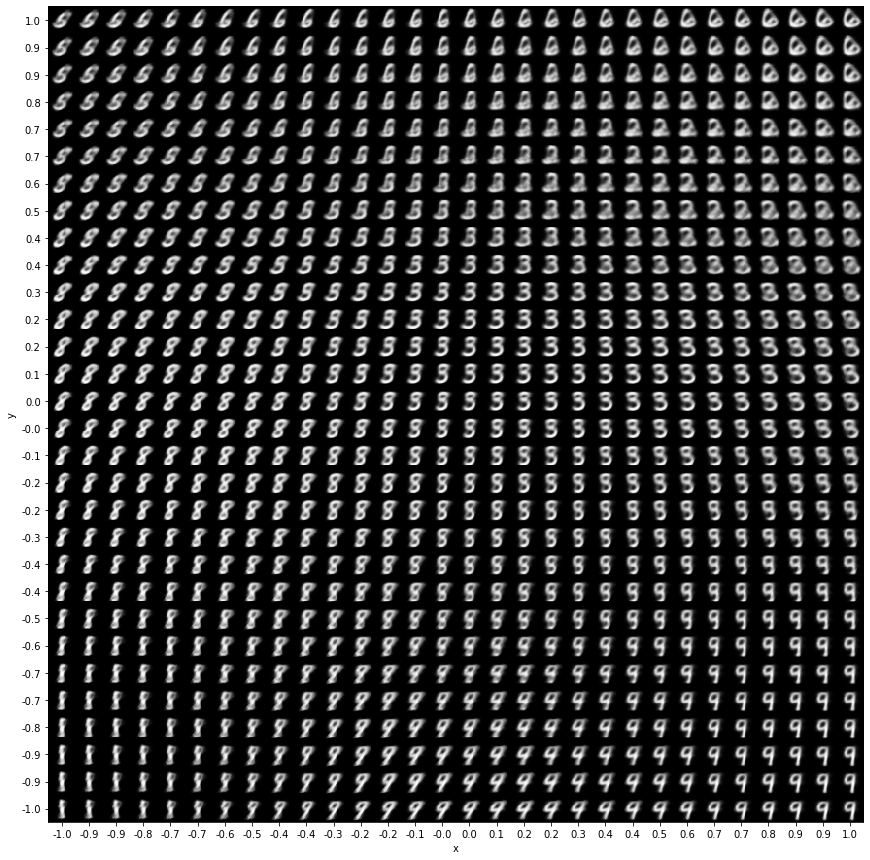

In [ ]:
PlotLatentSpace(model)

### 4.2 Label clusters

In [ ]:
def PlotLabelClusters(model, data, labels):
    data = data.reshape(-1,784)
    mu, std = model.encoder(data)
    x_e = model.reparameterize(mu, std)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x_e[:, 0], x_e[:, 1], c=labels)
    plt.colorbar()
    plt.title('Label Clusters')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

#### 4.2.1 training data

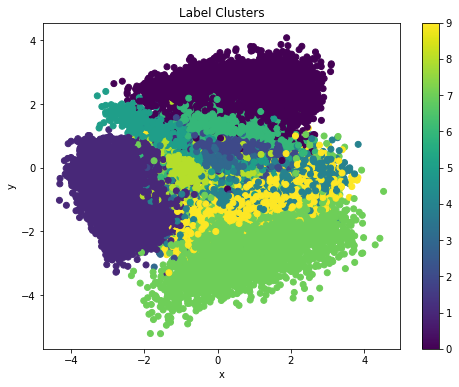

In [ ]:
PlotLabelClusters(model, tr_img, tr_lab)

#### 4.2.2 testing data

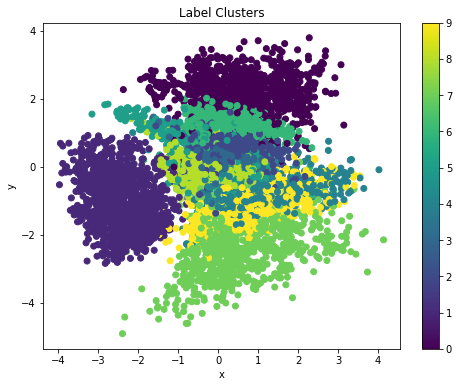

In [ ]:
PlotLabelClusters(model, ts_img, ts_lab)